## Control Variables
- Resolution = 0.25
- ROBOT_RADIUS = 0.25
- NUM_OF_AGENT = 10
- ANN Samples = 199
- https://github.com/facebookresearch/SEAL_OGB
- https://docs.dgl.ai/guide/training-node.html
- https://docs.dgl.ai/guide/training-edge.html#guide-training-edge-classification

- https://arxiv.org/pdf/1802.09691.pdf
- https://arxiv.org/pdf/2010.16103.pdf
- https://arxiv.org/abs/1706.02216

In [117]:
import BayesianOptimisation.boVoronoiDirected as boVoronoiDirected
import BayesianOptimisation.expGrid as expGrid
import BayesianOptimisation.expVoronoi as expVoronoi
import BayesianOptimisation.bo2VoronoiDirected as bo2VoronoiDirected
import BayesianOptimisation.experiment_setup as experiment
from core.DataStructure import *

from importlib import reload
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import Rectangle
import copy

In [1]:
import BayesianOptimisation.boVoronoiDirected as boVoronoiDirected
import BayesianOptimisation.expGrid as expGrid
import BayesianOptimisation.expVoronoi as expVoronoi
import BayesianOptimisation.genVoronoiDirected as genVoronoiDirected
import BayesianOptimisation.experiment_setup as experiment
from core.DataStructure import *


import copy
import pandas as pd
from scipy.optimize import minimize, Bounds
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, Reshape
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import train_test_split

from torch_geometric.utils.convert import from_networkx, to_networkx
import networkx as nx
from torch_geometric.data import Data, DataLoader

from typing import Optional
import torch
from torch import Tensor
import torch.nn.functional as F
from torch.nn import ModuleList, Sequential, Linear, BatchNorm1d, ReLU, Dropout, Sigmoid
from pytorch_lightning.metrics import Accuracy
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning import (LightningDataModule, LightningModule, Trainer,
                               seed_everything)

from torch_sparse import SparseTensor
from torch_scatter import segment_csr
import torch_geometric.transforms as T
from torch_geometric.nn import GINConv
from torch_geometric.datasets import TUDataset
from torch_geometric.data import Batch, DataLoader

from torch_geometric.utils import train_test_split_edges

In [44]:
X_read = pd.read_csv("./data/gen-starts-ends/X.csv")
X = X_read.to_numpy()
locations = X.reshape((-1,10,4))

X_read = pd.read_csv("./data/gen-starts-ends/Y.csv")
X = X_read.to_numpy()
probabilities = X.reshape((199,-1))

X_read = pd.read_csv("./data/gen-starts-ends/trainable_edges.csv")
X = X_read.to_numpy()
edges = X.reshape((-1,4))

In [3]:
# Node as node
# assigned = []
# nodes = []
# n_to_loc = {}
# loc_to_n = {}
# for e in edges:
#     for i in range (0,4,2):
#         if frozenset(e[i:i+2]) not in assigned:
#             assigned.append(frozenset(e[i:i+2]))
#             nodes.append(e[i:i+2])
#             n_to_loc[len(nodes)-1] = e[i:i+2]
#             loc_to_n[frozenset(e[i:i+2])] = len(nodes)-1
            
# temp_G = nx.Graph()
# for e in edges:
#     n1 = loc_to_n[frozenset(e[0:2])]
#     n2 = loc_to_n[frozenset(e[2:4])]
#     temp_G.add_nodes_from([
#         (n1, {"position": e[0:2]}),
#         (n2, {"position": e[2:4]}),
#     ])
#     temp_G.add_edge(n1,n2)

In [38]:
# starts = edges[:,:2]
# ends = edges[:,:2]
# starts_loc_to_n = {frozenset(k): v for v, k in enumerate(starts)}
# starts_n_to_loc = {v: k for v, k in enumerate(starts)}
# ends_loc_to_n = {frozenset(k): v for v, k in enumerate(ends)}
# ends_n_to_loc = {v: k for v, k in enumerate(ends)}

447

In [46]:
# locations.shape

(199, 10, 4)

In [48]:
# starts = locations[:,:,:2]
# ends = locations[:,:,2:]
# starts_loc_to_n = {frozenset(k): v for v, k in enumerate(starts)}
# starts_n_to_loc = {v: k for v, k in enumerate(starts)}
# ends_loc_to_n = {frozenset(k): v for v, k in enumerate(ends)}
# ends_n_to_loc = {v: k for v, k in enumerate(ends)}

In [51]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
num_nodes = 447

# Edge as Node
data_list =[]
for sam in range(199):
    sample = sam
    
    starts = locations[sample,:,:2]
    ends = locations[sample,:,2:]
    starts_loc_to_n = {frozenset(k): v for v, k in enumerate(starts)}
    starts_n_to_loc = {v: k for v, k in enumerate(starts)}
    ends_loc_to_n = {frozenset(k): v for v, k in enumerate(ends)}
    ends_n_to_loc = {v: k for v, k in enumerate(ends)}
    
    G = nx.Graph()
    connecting_edges = []

    for idx, e in enumerate(edges):
        # Add info about start end locations
        # [1,0,0,0] => e[0:2] is start
        case = np.zeros(4)
        if frozenset(e[0:2]) in starts_loc_to_n.keys():
            np.add(case, np.array([1,0,0,0]))
        if frozenset(e[0:2]) in ends_loc_to_n.keys():
            np.add(case, np.array([0,1,0,0]))
        if frozenset(e[2:4]) in starts_loc_to_n.keys():
            np.add(case, np.array([0,0,1,0]))
#         if frozenset(e[2:4]) in ends_loc_to_n.keys():
            np.add(case, np.array([0,0,0,1]))
        
        G.add_nodes_from([
#             (idx, {"position": e,"probability": probabilities[sample,idx]}),
            (idx, {"position": e, "x": case}),
        ])

    for cur, e in enumerate(edges):
        for ite in range(0,4,2):
            #find connecting edges
            if frozenset(e[ite:ite+2]) in starts_loc_to_n.keys():
                neigh = starts_loc_to_n[frozenset(e[ite:ite+2])]
                if neigh != cur:
                    G.add_edge(cur, neigh)
            if frozenset(e[ite:ite+2]) in ends_loc_to_n.keys():
                neigh = ends_loc_to_n[frozenset(e[ite:ite+2])]
                if neigh != cur:
                    G.add_edge(cur, neigh)

    data_g = from_networkx(G)
    data_g.y = torch.from_numpy(probabilities[sample][:-3]).float()
    adj = SparseTensor(row=data_g.edge_index[0], col=data_g.edge_index[1], sparse_sizes=(num_nodes, num_nodes))
    data_g.adj_t = adj
#     train_data = np.zeros(len(data_g.y))
#     train_data[:300] = True
#     arr1 = train_data.astype(np.bool)
#     arr2 = np.logical_not(train_data).astype(np.bool)
#     data_g.train_mask = torch.from_numpy(arr1).type(torch.bool)
#     data_g.test_mask = torch.from_numpy(arr2).type(torch.bool)
    data_list.append(data_g)

In [6]:
# loader = DataLoader(data_list, batch_size=32)

### Model

In [7]:
# k = T.Compose([
#     T.OneHotDegree(4 - 1),
#     T.ToSparseTensor(),
# ])

# loader = DataLoader(data_list, batch_size=32)
# k(data_list[0])


In [52]:
class MyOwnDataset(LightningDataModule):
    def __init__(self, raw_data_list):
        super().__init__()
        self.raw_data_list = raw_data_list
        self.transform = T.Compose([
            T.ToSparseTensor(),
        ])

    @property
    def num_features(self) -> int:
        return 4

    @property
    def num_classes(self) -> int:
        return 447

    def setup(self, stage: Optional[str] = None):
        dataset = self.raw_data_list
        
        for d in dataset:
            self.transform(d)
        
        self.test_dataset = dataset[:len(dataset) // 10]
        self.val_dataset = dataset[len(dataset) // 10:len(dataset) // 5]
        self.train_dataset = dataset[len(dataset) // 5:]

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=32, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=32)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=32)
        

In [53]:
class GIN(LightningModule):
    def __init__(self, in_channels: int, out_channels: int,
                 hidden_channels: int = 64, num_layers: int = 3, 
                 dropout: float = 0.5):
        super().__init__()
        self.save_hyperparameters()

        self.convs = ModuleList()
        for _ in range(num_layers):
            mlp = Sequential(
                Linear(in_channels, 2 * hidden_channels),
                BatchNorm1d(2 * hidden_channels),
                ReLU(inplace=True),
                Linear(2 * hidden_channels, hidden_channels),
                BatchNorm1d(hidden_channels),
                ReLU(inplace=True),
            )
            conv = GINConv(mlp, train_eps=True)
            self.convs.append(conv)
            in_channels = hidden_channels

        self.regressor = Sequential(
            Linear(hidden_channels, hidden_channels),
            BatchNorm1d(hidden_channels),
            ReLU(inplace=True),
#             Dropout(p=dropout),
            Linear(hidden_channels, out_channels),
            Sigmoid(),
        )
        

#         self.train_acc = Accuracy()
#         self.val_acc = Accuracy()
#         self.test_acc = Accuracy()
#         self.train_loss = Loss()
#         self.val_loss = Loss()
#         self.test_loss = Loss()
        

    def forward(self, x: Tensor, adj_t: SparseTensor, ptr: Tensor) -> Tensor:
        for conv in self.convs:
            x = conv(x.float(), adj_t)
        x = segment_csr(x, ptr, reduce='sum')  # Global add pooling.
        return self.regressor(x)

    def training_step(self, batch: Batch, batch_idx: int):
        y_hat = self(batch.x, batch.adj_t, batch.ptr)
        a = y_hat
        b = torch.reshape(batch.y, (-1, 447))
        train_loss = F.mse_loss(a,b)
        self.log('train_loss', train_loss, prog_bar=True, on_step=False,
                 on_epoch=True)
        return train_loss

    def validation_step(self, batch: Batch, batch_idx: int):
        y_hat = self(batch.x, batch.adj_t, batch.ptr)
        a = y_hat
        b = torch.reshape(batch.y, (-1, 447))
        val_loss = F.mse_loss(a,b)
        self.log('val_loss', val_loss, prog_bar=True, on_step=False,
                 on_epoch=True)
        return val_loss

    def test_step(self, batch: Batch, batch_idx: int):
        y_hat = self(batch.x, batch.adj_t, batch.ptr)
        a = y_hat
        b = torch.reshape(batch.y, (-1, 447))
        test_loss = F.mse_loss(a,b)
        self.log('test_loss', test_loss, prog_bar=True, on_step=False,
                 on_epoch=True)
        return test_loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.0001)
    

In [54]:
seed_everything(42)
data_l = copy.deepcopy(data_list)
datamodule = MyOwnDataset(data_l)
datamodule.setup()

Global seed set to 42


### Training

In [56]:
model = GIN(datamodule.num_features, datamodule.num_classes)
checkpoint_callback = ModelCheckpoint(dirpath='./data/gnn', monitor='val_loss', mode='min', save_top_k=1)
trainer = Trainer(gpus=1, max_epochs=10, callbacks=[checkpoint_callback])

# Uncomment to train on multiple GPUs:
# trainer = Trainer(gpus=2, accelerator='ddp', max_epochs=20,
#                   callbacks=[checkpoint_callback])

trainer.fit(model, datamodule=datamodule)
trainer.test()

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | convs     | ModuleList | 43.2 K
1 | regressor | Sequential | 33.3 K
-----------------------------------------
76.5 K    Trainable params
0         Non-trainable params
76.5 K    Total params
0.306     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

ptr tensor([   0,  447,  894, 1341, 1788, 2235, 2682, 3129, 3576, 4023, 4470, 4917,
        5364, 5811, 6258, 6705, 7152, 7599, 8046, 8493], device='cuda:0')
--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.08904783427715302}
--------------------------------------------------------------------------------


[{'test_loss': 0.08904783427715302}]

### Testing on singel sample

In [103]:
sample = 198

starts = locations[sample,:,:2]
ends = locations[sample,:,2:]
starts_loc_to_n = {frozenset(k): v for v, k in enumerate(starts)}
starts_n_to_loc = {v: k for v, k in enumerate(starts)}
ends_loc_to_n = {frozenset(k): v for v, k in enumerate(ends)}
ends_n_to_loc = {v: k for v, k in enumerate(ends)}

G = nx.Graph()
connecting_edges = []

for idx, e in enumerate(edges):
    # Add info about start end locations
    # [1,0,0,0] => e[0:2] is start
    case = np.zeros(4)
    if frozenset(e[0:2]) in starts_loc_to_n.keys():
        np.add(case, np.array([1,0,0,0]))
    if frozenset(e[0:2]) in ends_loc_to_n.keys():
        np.add(case, np.array([0,1,0,0]))
    if frozenset(e[2:4]) in starts_loc_to_n.keys():
        np.add(case, np.array([0,0,1,0]))
#         if frozenset(e[2:4]) in ends_loc_to_n.keys():
        np.add(case, np.array([0,0,0,1]))

    G.add_nodes_from([
#             (idx, {"position": e,"probability": probabilities[sample,idx]}),
        (idx, {"position": e, "x": case}),
    ])

for cur, e in enumerate(edges):
    for ite in range(0,4,2):
        #find connecting edges
        if frozenset(e[ite:ite+2]) in starts_loc_to_n.keys():
            neigh = starts_loc_to_n[frozenset(e[ite:ite+2])]
            if neigh != cur:
                G.add_edge(cur, neigh)
        if frozenset(e[ite:ite+2]) in ends_loc_to_n.keys():
            neigh = ends_loc_to_n[frozenset(e[ite:ite+2])]
            if neigh != cur:
                G.add_edge(cur, neigh)

data_g = from_networkx(G)
data_g.y = torch.from_numpy(probabilities[sample][:-3]).float()
adj = SparseTensor(row=data_g.edge_index[0], col=data_g.edge_index[1], sparse_sizes=(num_nodes, num_nodes))
data_g.adj_t = adj
temp = np.zeros(20).astype(int)
# temp = np.array([0,  447,  894, 1341, 1788, 2235, 2682, 3129, 3576, 4023, 4470, 4917, 5364, 5811, 6258, 6705, 7152, 7599, 8046, 8493])
data_g.ptr = torch.from_numpy(temp)

In [104]:
rmodel

GIN(
  (convs): ModuleList(
    (0): GINConv(nn=Sequential(
      (0): Linear(in_features=4, out_features=128, bias=True)
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Linear(in_features=128, out_features=64, bias=True)
      (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    ))
    (1): GINConv(nn=Sequential(
      (0): Linear(in_features=64, out_features=128, bias=True)
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Linear(in_features=128, out_features=64, bias=True)
      (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    ))
    (2): GINConv(nn=Sequential(
      (0): Linear(in_features=64, out_features=128, bias=True)
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=Tr

In [105]:
rmodel = GIN(datamodule.num_features, datamodule.num_classes)
path = checkpoint_callback.best_model_path
rmodel.load_from_checkpoint(checkpoint_path=path)
rmodel.freeze()
out = rmodel(data_g.x, data_g.adj_t, data_g.ptr)[0]

In [106]:
out.numpy()

array([0.51050186, 0.5170855 , 0.5093229 , 0.474993  , 0.53247243,
       0.5071284 , 0.478781  , 0.4868563 , 0.497228  , 0.5244495 ,
       0.4994011 , 0.52636015, 0.5072379 , 0.5078909 , 0.51374483,
       0.4765622 , 0.517726  , 0.46604827, 0.5005789 , 0.54411936,
       0.4746751 , 0.4875618 , 0.46633223, 0.4832639 , 0.48848408,
       0.48784694, 0.51044375, 0.48862195, 0.47255823, 0.50119555,
       0.49329993, 0.513088  , 0.51484436, 0.5355671 , 0.4751445 ,
       0.46784678, 0.4741164 , 0.49105787, 0.5147887 , 0.49391925,
       0.5279798 , 0.49253774, 0.48165977, 0.4888864 , 0.46960518,
       0.49269274, 0.48055625, 0.5287622 , 0.47203338, 0.48033395,
       0.48513848, 0.52840954, 0.51825005, 0.5353131 , 0.4844653 ,
       0.5221541 , 0.5287732 , 0.5252235 , 0.4895362 , 0.50210744,
       0.53697205, 0.49913064, 0.49082813, 0.47025767, 0.47788894,
       0.51586777, 0.5055515 , 0.51589   , 0.5049596 , 0.48221338,
       0.5127496 , 0.52638745, 0.50712776, 0.51022816, 0.48921

In [ ]:
# probabilities = out.numpy()
# start = starts
# end = ends
# edge_loc = edges

# G_f = nx.MultiDiGraph()
# for e in edge_loc:
#     G_f.add_edge()

In [79]:
# dataset = copy.deepcopy(data_list)
# test_dataset = dataset[:len(dataset) // 10]
# G_test = to_networkx(test_dataset[0])

# num_nodes = 447
# data_g = from_networkx(G_test)
# adj = SparseTensor(row=data_g.edge_index[0], col=data_g.edge_index[1], sparse_sizes=(num_nodes, num_nodes))
# data_g.adj_t = adj
# data_g.ptr = Tensor


In [108]:
DATASET = 25
probabilities = out.numpy()
scene = "./input/random-32-32-10/scen-even/random-32-32-10-even-" + str(DATASET) + ".scen"
exp = experiment.Experiment(scene=scene)

In [113]:
sample = 198
starts = locations[sample,:,:2]
ends = locations[sample,:,2:]

total number of distance 440
Number of trainable probabilities 377
Length cutoff threshold 2
Black px 106659 White px 79965


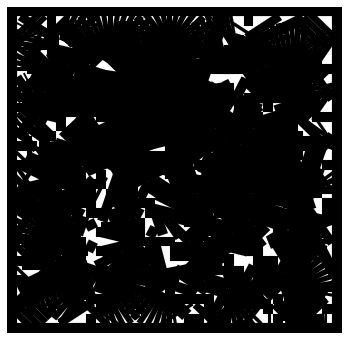

In [118]:
output = bo2VoronoiDirected.get_results(probabilities, exp)
vordir_paths, vordir_cost, vordir_ft, vordir_u1, vordir_u2, vordir_con, vordir_conmax, vordir_conavg, vordir_G0, vordir_G, vordir_thres = output
vordir_u2 = getCoverage(exp,vordir_G, directed = True)

In [115]:
def getCoverage(exp, G, directed = False):
    total_area = 0
    total_dist = 0
    assigned = {}
    fig, ax = plt.subplots(figsize=(6,6))
    plt.xlim(0,34)
    plt.ylim(0,34)
    count = 0
    for n in G.nodes:
        for e in G.neighbors(n):
            if n != e and frozenset((n, e)) not in assigned.keys():
                
                p1 = G.nodes[n]['position']
                p2 = G.nodes[e]['position']
                
                if (directed):
                    d = G.edges[n,e,0]['distance']
                    c = G.edges[n,e,0]['capacity']
                else:
                    d = G.edges[n,e]['distance']
                    c = G.edges[n,e]['capacity']
                
                
                assigned[frozenset((n, e))] = 1

                adjustp1 = Point(p1.y, p1.x)
                adjustp2 = Point(p2.y, p2.x)

                refpt1 = adjustp1 if adjustp1.y <= adjustp2.y else adjustp2
                refpt2 = adjustp1 if adjustp1.y > adjustp2.y else adjustp2

                if refpt1.x >= refpt2.x:
                    theta_rot = np.pi - np.arctan(abs(refpt1.y - refpt2.y)/abs(refpt1.x - refpt2.x))
                else:
                    theta_rot = np.arctan(abs(refpt1.y - refpt2.y)/abs(refpt1.x - refpt2.x))

                if theta_rot >= np.pi/2:
                    theta = theta_rot - np.pi/2
                else:
                    theta = theta_rot + np.pi/2

                dy = -(c/2)*np.sin(theta)
                if refpt1.y == refpt2.y:
                    dx = 0
                    width = d
                    height = c
                    a = 0
                elif refpt1.x > refpt2.x:
                    dx = -(c/2)*np.cos(theta)
                    width = c
                    height = d
                    a = (theta) * 180 / np.pi
                elif refpt1.x == refpt2.x:
                    dx = -(c/2)
                    width = c
                    height = d
                    a = 0
                else:
                    dx = (c/2)*np.cos(np.pi - theta)
                    width = d
                    height = c
                    a = (theta_rot) * 180 / np.pi
                    

                rect = Rectangle((refpt1.x+dx,refpt1.y+dy),width,height,linewidth=0.1,fill=True, angle = a,color = 'black')
                plt.gca().add_patch(rect)
                count +=1

    for o in exp.obstacles_loc:
        adjustedx, adjustedy = o[1],o[0]
        rect = Rectangle((adjustedx-0.5,adjustedy-0.5),1,1,linewidth=0.1,fill=True, angle = 0, color = 'black')
        plt.gca().add_patch(rect)

    ax.axis('off')

    im = fig
    im.canvas.draw()
    X = np.array(im.canvas.renderer._renderer)
    X_reshape = X.reshape((-1,4))
    X_reshape = np.delete(X_reshape, [1,2,3], axis = 1)
    black = np.count_nonzero(X_reshape == 0)
    white= np.count_nonzero(X_reshape == 255)
    print("Black px", black, "White px", white)
    percentage = black/(white+black)
    return percentage

In [119]:
def showAccSolution(result_graph, paths, image, nodes, start_nodes, end_nodes, all_path = True, path_num = 0):
    edges_in_path = []
    image2 = 1-image
    fig, ax = plt.subplots(figsize=(12,12))
    img = np.array(1-image)
    ax = sb.heatmap(img)
    assigned = {}
    
    for index, path in enumerate(paths):
#         path = paths[path_num]
        for ite in range(len(path)-1):
            edges_in_path.append(np.array([path[ite],path[ite+1],0]))
            p1 = result_graph.nodes[path[ite]]['position']
            p2 = result_graph.nodes[path[ite+1]]['position']

            for r in (p1.x, p2.x, 1):
                for c in (p1.y, p2.y, 1):
                    if (Point(r,c) in np.array(nodes)[end_nodes]):
                        image2[int(r),int(c)] = 1
                    else:
                        image2[int(r),int(c)] += 0.2

        drawn = {}
        loop = result_graph.edges if all_path else edges_in_path

        for elem in loop:
            cur = result_graph.edges[elem[0], elem[1], 0]['probability']
            opposite = result_graph.edges[elem[1], elem[0], 0]['probability']
            unused = 1 - cur - opposite
            scaler = 0.7
            if cur > opposite:
                p1 = result_graph.nodes[elem[0]]['position']
                arr1 = np.array([p1.x,p1.y])
                p2 = result_graph.nodes[elem[1]]['position']
                arr2 = np.array([p2.x,p2.y])
                direction = (arr2-arr1) / np.linalg.norm(arr2 - arr1)
                mag = np.linalg.norm(arr2 - arr1)*scaler
                dx, dy = mag*direction
            else:
                p1 = result_graph.nodes[elem[1]]['position']
                arr1 = np.array([p1.x,p1.y])
                p2 = result_graph.nodes[elem[0]]['position']
                arr2 = np.array([p2.x,p2.y])
                direction = (arr2-arr1) / np.linalg.norm(arr2 - arr1)
                mag = np.linalg.norm(arr2 - arr1)*scaler
                dx, dy = mag*direction
            
            # only draw arrow once
            if frozenset((p1.y, p1.x, dy, dx)) not in assigned.keys():
                plt.arrow(p1.y, p1.x, dy, dx, head_width = 0.35, alpha=0.9, color = 'grey', linewidth=1)
                assigned[frozenset((p1.y, p1.x, dy, dx))] = 1
            
#         p = start_nodes[index]
#         plt.scatter(nodes[p].y, nodes[p].x, color = 'red', linewidths=5)
#         p = end_nodes[index]
#         plt.scatter(nodes[p].y, nodes[p].x, color = 'lime', linewidths=5)
#         name = './results/vordir_path'+ str(path_num)+'.png'
#         plt.gca().invert_yaxis()
#         plt.savefig(name)
        
    for p in start_nodes:
        plt.scatter(nodes[p].y, nodes[p].x, color = 'red', linewidths=5)
    for p in end_nodes:
        plt.scatter(nodes[p].y, nodes[p].x, color = 'lime', linewidths=5)

#     name = './data/'+ 'ANN' +'.png'
    plt.gca().invert_yaxis()
#     plt.savefig(name)
    return fig

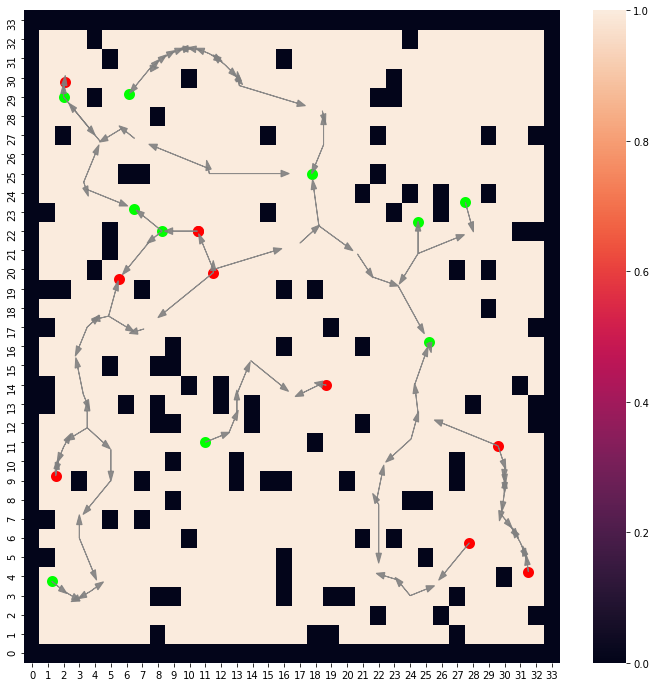

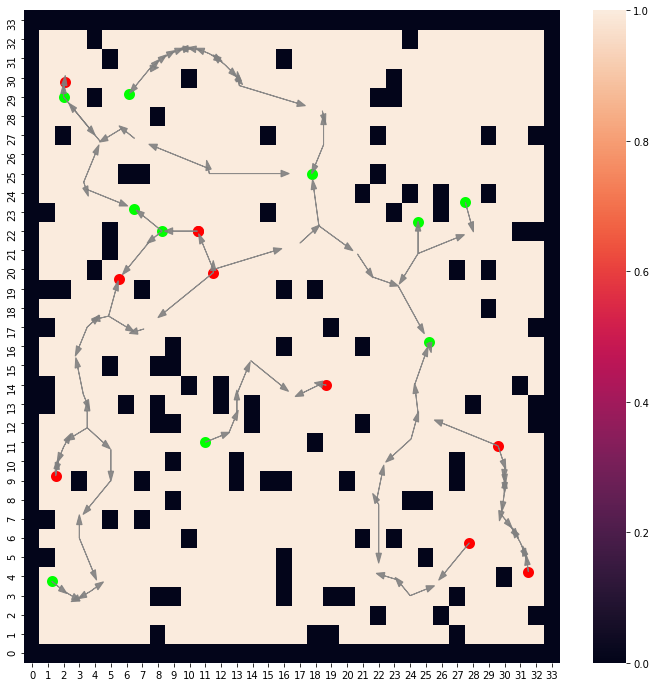

In [120]:
showAccSolution(vordir_G0, 
                vordir_paths, 
                exp.image, 
                exp.nodes, 
                exp.start_nodes, 
                exp.end_nodes, 
                all_path = False, 
                path_num = 0) #path_num variables is unused

### End

In [180]:
# class IMDBBinary(LightningDataModule):
#     def __init__(self, data_dir):
#         super().__init__()
#         self.data_dir = data_dir
#         self.transform = T.Compose([
#             T.OneHotDegree(self.num_features - 1),
#             T.ToSparseTensor(),
#         ])

#     @property
#     def num_features(self) -> int:
#         return 136

#     @property
#     def num_classes(self) -> int:
#         return 2

#     def prepare_data(self):
#         TUDataset(self.data_dir, name='IMDB-BINARY',
#                   pre_transform=self.transform)

#     def setup(self, stage: Optional[str] = None):
#         dataset = TUDataset(self.data_dir, name='IMDB-BINARY',
#                             pre_transform=self.transform).shuffle()

#         self.test_dataset = dataset[:len(dataset) // 10]
#         self.val_dataset = dataset[len(dataset) // 10:len(dataset) // 5]
#         self.train_dataset = dataset[len(dataset) // 5:]

#     def train_dataloader(self):
#         return DataLoader(self.train_dataset, batch_size=64, shuffle=True)

#     def val_dataloader(self):
#         return DataLoader(self.val_dataset, batch_size=128)

#     def test_dataloader(self):
#         return DataLoader(self.test_dataset, batch_size=128)

In [178]:
# seed_everything(42)
# datamodule1 = IMDBBinary('data/TUDataset')
# datamodule1.setup()
# model1 = GIN(datamodule1.num_features, datamodule1.num_classes)

In [179]:
# datamodule1.test_dataset[0]

In [176]:
# datamodule.test_dataset[0]

In [177]:
# import os.path as osp

# import torch
# import torch.nn.functional as F
# from torch.nn import BatchNorm1d
# from sklearn.metrics import f1_score
# from torch_geometric.nn import FiLMConv
# from torch_geometric.datasets import PPI
# from torch_geometric.data import DataLoader

# # path = osp.join(osp.dirname(osp.realpath(__file__)), '..', 'data', 'PPI')
# # train_dataset = PPI(path, split='train')
# # val_dataset = PPI(path, split='val')
# # test_dataset = PPI(path, split='test')
# dataset = MyOwnDataset(data_list)
# dataset.setup()
# train_loader = dataset.train_dataloader()
# val_loader = dataset.val_dataloader()
# test_loader = dataset.test_dataloader()


# class Net(torch.nn.Module):
#     def __init__(self, in_channels, hidden_channels, out_channels, num_layers,
#                  dropout=0.0):
#         super(Net, self).__init__()
#         self.dropout = dropout

#         self.convs = torch.nn.ModuleList()
#         self.convs.append(FiLMConv(in_channels, hidden_channels))
#         for _ in range(num_layers - 2):
#             self.convs.append(FiLMConv(hidden_channels, hidden_channels))
#         self.convs.append(FiLMConv(hidden_channels, out_channels, act=None))

#         self.norms = torch.nn.ModuleList()
#         for _ in range(num_layers - 1):
#             self.norms.append(BatchNorm1d(hidden_channels))

#     def forward(self, x, edge_index):
#         for conv, norm in zip(self.convs[:-1], self.norms):
#             x = norm(conv(x, edge_index))
#             x = F.dropout(x, p=self.dropout, training=self.training)
#         x = self.convs[-1](x, edge_index)
#         return x


# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = Net(in_channels=dataset.num_features, hidden_channels=320,
#             out_channels=dataset.num_classes, num_layers=4,
#             dropout=0.1).to(device)
# criterion = torch.nn.BCEWithLogitsLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=0.01)


# def train():
#     model.train()

#     total_loss = 0
#     for data in train_loader:
#         data = data.to(device)
#         optimizer.zero_grad()
#         print("Size", data.x.shape, data.edge_index.shape, data.y.shape)
        
#         loss = criterion(model(data.x, data.edge_index), data.y)
#         total_loss += loss.item() * data.num_graphs
#         loss.backward()
#         optimizer.step()
#     return total_loss / len(train_loader.dataset)


# @torch.no_grad()
# def test(loader):
#     model.eval()

#     ys, preds = [], []
#     for data in loader:
#         ys.append(data.y)
#         out = model(data.x.to(device), data.edge_index.to(device))
#         preds.append((out > 0).float().cpu())

#     y, pred = torch.cat(ys, dim=0).numpy(), torch.cat(preds, dim=0).numpy()
#     return f1_score(y, pred, average='micro') if pred.sum() > 0 else 0


# for epoch in range(1, 5):
#     loss = train()
#     val_f1 = test(val_loader)
#     test_f1 = test(test_loader)
#     print('Epoch: {:02d}, Loss: {:.4f}, Val: {:.4f}, Test: {:.4f}'.format(
#         epoch, loss, val_f1, test_f1))